# dask based

In [ ]:
''' dask based '''
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import dask
import dask.dataframe as dd
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

dtypes = {"aggregation_year": 'uint16', "permanent_area": 'float64',
          "seasonal_area": 'float64',
          "maybepermanent": 'float64',
          "maybeseasonal": 'float64'
         }

data_dir =  Path('data')
cols_required = ['permanent_area', 
                 # 'seasonal_area'
                #  'maybepermanent', 'maybeseasonal'
                ]

arr_mean_std = []

meta = {'id': 'str', 't_score': 'float', 'u_score': 'float', 'p_t': 'float', 'p_u': 'float', 'p_u_thd_0.01': 'bool'} #'id_bgl': 'object', 'start_year': int, 'basin_level': int
meta_adm0 = {'id': 'str', 'adm0_name': 'str', 't_score': 'float', 'u_score': 'float', 'p_t': 'float', 'p_u': 'float', 'p_u_thd_0.01': 'bool'} #'id_bgl': 'object', 'start_year': int, 'basin_level': int
# meta.update({col: 'float16' for col in cols_required})

def t_test_and_u_test(group, p_thd = 0.01):
    id = group.index[0] # basin_id
    
    patch = group[(group.index == id) & (group['aggregation_year']  >=2000)]
    baseline_period = list(patch[patch['aggregation_year'] < 2020]['permanent_area'].values)
    report_period = list(patch[patch['aggregation_year'] >= 2017]['permanent_area'].values)

    # T-test
    t_score, p_t = stats.ttest_ind(report_period, baseline_period)

    # U-Test
    u_score, p_u = stats.mannwhitneyu(report_period, baseline_period, equal_var=False)
    median_report = np.median(report_period)
    median_baseline = np.median(baseline_period)
    median_diff = median_report - median_baseline
    u_score = median_diff / np.abs(median_diff) * u_score

    p_u_thd = float(p_u <= p_thd)

    df = pd.DataFrame([[id, t_score, u_score, p_t, p_u, p_u_thd]], columns=['id', 't_score', 'u_score', 'p_t', 'p_u', 'p_u_thd_0.01'])
    return df



# if __name__ == '__main__':
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(dashboard_address=':38787')
client = Client(cluster)#timeout

for folder in ["Pemanent_water", "Reservoirs"]: # Reservoirs, Pemanent_water

    output_dir = data_dir / f"outputs_utest" / folder
    output_dir.mkdir(exist_ok=True, parents=True)
    print(output_dir)

    # basin-level analysis
    # for basin_level in [0, 3, 4, 5, 6, 7, 8]:
    for basin_level in [3]:
        print()
        print(f"basins_level: {basin_level}")
    
        url = data_dir / folder / f"basins_level_{basin_level}_ts.csv"
        basin = dd.read_csv(url, include_path_column=False, dtype=dtypes).repartition(npartitions=80).set_index(f'id_bgl_{basin_level}')
        
        ''' for debug '''
        # number = 31
        # df_delta = basin.groupby(f'id_bgl_{basin_level}', group_keys=False)
        # t_test_and_u_test(df_delta.get_group("112_262").compute(), basin_level)
    
        # df_delta = basin.groupby(f'id_bgl_{basin_level}', group_keys=False).apply(calculate_delta, basin_level, epision, meta=meta)
        df_delta = basin.groupby(f'id_bgl_{basin_level}', group_keys=False).apply(t_test_and_u_test, meta=meta).set_index('id')
       
        df_delta = df_delta.compute()
        df_delta.to_csv(output_dir / f"basins_level_{basin_level}_t_test.csv")


# non-dask

In [12]:
''' non-dask '''
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

dtypes = {"aggregation_year": 'uint16', "permanent_area": 'float64',
          "seasonal_area": 'float64',
          "maybepermanent": 'float64',
          "maybeseasonal": 'float64'
         }

data_dir =  Path('data')
cols_required = ['permanent_area', 
                 # 'seasonal_area'
                #  'maybepermanent', 'maybeseasonal'
                ]

arr_mean_std = []

meta = {'id': 'str', 't_score': 'float', 'u_score': 'float', 'p_t': 'float', 'p_u': 'float', 'p_u_thd_0.01': 'bool'} #'id_bgl': 'object', 'start_year': int, 'basin_level': int
meta_adm0 = {'id': 'str', 'adm0_name': 'str', 't_score': 'float', 'u_score': 'float', 'p_t': 'float', 'p_u': 'float', 'p_u_thd_0.01': 'bool'} #'id_bgl': 'object', 'start_year': int, 'basin_level': int
# meta.update({col: 'float16' for col in cols_required})

def t_test_and_u_test(group, p_thd = 0.01):
    id = group.index[0] # basin_id
    
    patch = group[(group.index == id) & (group['aggregation_year']  >=2000)]
    baseline_period = list(patch[patch['aggregation_year'] < 2020]['permanent_area'].values)
    report_period = list(patch[patch['aggregation_year'] >= 2017]['permanent_area'].values)

    # T-test
    t_score, p_t = stats.ttest_ind(report_period, baseline_period)

    # U-Test
    u_score, p_u = stats.mannwhitneyu(report_period, baseline_period)
    median_report = np.median(report_period)
    median_baseline = np.median(baseline_period)
    median_diff = median_report - median_baseline
    u_score = median_diff / np.abs(median_diff) * u_score

    p_u_thd = float(p_u < p_thd)

    df = pd.DataFrame([[id, t_score, u_score, p_t, p_u, p_u_thd]], columns=['id', 't_score', 'u_score', 'p_t', 'p_u', 'p_u_thd_0.01'])
    return df

for folder in ["Pemanent_water", "Reservoirs"]: # Reservoirs, Pemanent_water

    output_dir = Path("outputs_utest") / folder
    output_dir.mkdir(exist_ok=True, parents=True)
    print(output_dir)

    # basin-level analysis
    # for basin_level in [0, 3, 4, 5, 6, 7, 8]:
    for basin_level in [3]:
        print()
        print(f"basins_level: {basin_level}")
    
        url = data_dir / folder / f"basins_level_{basin_level}_ts.csv"
        basin = dd.read_csv(url, include_path_column=False, dtype=dtypes).repartition(npartitions=80).set_index(f'id_bgl_{basin_level}')
        
        ''' for debug '''
        # number = 31
        # df_delta = basin.groupby(f'id_bgl_{basin_level}', group_keys=False)
        # t_test_and_u_test(df_delta.get_group("112_262").compute(), basin_level)
    
        # df_delta = basin.groupby(f'id_bgl_{basin_level}', group_keys=False).apply(calculate_delta, basin_level, epision, meta=meta)
        df_delta = basin.groupby(f'id_bgl_{basin_level}', group_keys=False).apply(t_test_and_u_test, meta=meta).set_index('id')
       
        df_delta = df_delta.compute()
        df_delta.to_csv(output_dir / f"basins_level_{basin_level}_utest.csv")

outputs_utest\Pemanent_water

basins_level: 3
outputs_utest\Reservoirs

basins_level: 3


# Abalysis on Delta

In [ ]:
# apply threshold
def apply_threshold(input, thd_low, thd_high):
    stb = input[(input['permanent_area'] >= thd_low) & (input['permanent_area'] <= thd_high)]
    neg = input[(input['permanent_area'] < thd_low)]
    pos = input[(input['permanent_area'] > thd_high)]
    return neg, stb, pos


data_dir = Path.home() / 'pz'
ttest_dir = data_dir / "outputs_ttest"
delta_dir = data_dir / "outputs_delta"

folder = "Reservoirs" # Reservoirs
basin_level = 4


''' t-TEST and u-TEST '''
# ttest = pd.read_csv(ttest_dir / folder / f"basins_level_{basin_level}_ttest.csv")

''' Delta (2017)  '''
# delta
delta_all = pd.read_csv(delta_dir / folder / f"basins_level_{basin_level}_ts_delta.csv")
delta_2017 = delta_all[delta_all['start_year']==2017]
total_num_basins = delta_2017.shape[0]
print(f"basin_level: {basin_level}, total number of basins: {total_num_basins}")

# mean and std
df_muStd = pd.read_csv(delta_dir / folder / "basin_level_mean_std.csv").set_index('basin_level')
mean = df_muStd['mean_permanent_area'][basin_level]
std = df_muStd['std_permanent_area'][basin_level]
print(f"(all years), mean: {mean}, std: {std}")

# delta outliers removed
delta_all_outliers_removed = pd.read_csv(delta_dir / folder / f"basins_level_{basin_level}_ts_delta_outliers_removed.csv")
delta_2017_rm = delta_all_outliers_removed[delta_all_outliers_removed['start_year']==2017]
des_2017 = delta_2017_rm.describe()
mean_2017 = des_2017.loc['mean', 'permanent_area']
std_2017 = des_2017.loc['std', 'permanent_area']
print(f"(2017) mean: {mean_2017}, std: {std_2017}")


res_arr = []
# for start_year in [2000, 2005, 2010, 2015, 2017]:
start_year = 2017
print()
print(f'+++++++++++++++++++++++++++++++++ {start_year} ++++++++++++++++++++++++++++++++++')
for alpha in [0.5, 1, 1.5, 2]:
    print()
    
    print(f"--------- apply all years thresholds (alpha = {alpha}) -----------")
    thd_high = mean + alpha * std
    thd_low = mean - alpha * std
    print(f"(all years, alpha = {alpha}), [{thd_low}, {thd_high}]")
    neg, stb, pos = apply_threshold(delta_2017, thd_low, thd_high)
    print(f"neg: {neg.shape[0]}, stable: {stb.shape[0]}, pos: {pos.shape[0]}")
    print(f"neg: {neg.shape[0] / total_num_basins * 100}, stable: {stb.shape[0] / total_num_basins * 100}, pos: {pos.shape[0] / total_num_basins * 100}")
    
    print(f"---------- apply 2017 thresholds (alpha = {alpha}) --------------")
    thr_2017_high = mean_2017 + alpha * std_2017
    thr_2017_low = mean_2017 - alpha * std_2017
    print(f"(2017, alpha = {alpha}), [{thr_2017_low}, {thr_2017_high}]")
    neg_th17, stb_th17, pos_th17 = apply_threshold(delta_2017, thr_2017_low, thr_2017_high)
    print(f"neg: {neg_th17.shape[0]}, stable: {stb_th17.shape[0]}, pos: {pos_th17.shape[0]}")
    print(f"neg: {neg_th17.shape[0] / total_num_basins * 100}, stable: {stb_th17.shape[0] / total_num_basins * 100}, pos: {pos_th17.shape[0] / total_num_basins * 100}")

        # [basin_level, num_basins, mean, std, aplha, thd_low, thd_high, neg.shape[0], stb.shape[0], pos.shape[0]]


# Analysis on U-Test

In [9]:
''' T-Test '''
from pathlib import Path
import pandas as pd

ttest_dir = Path("outputs_utest")

for folder in ["Pemanent_water", "Reservoirs"]: # Reservoirs, Pemanent_water
    print(folder)
    
    res = []
    p_thd_list = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05][::-1]
    p_thd_cols = [f'p_thd_{p_thd}' for p_thd in p_thd_list]
    for basin_level in [0, 3, 4, 5, 6, 7, 8]:
        url = ttest_dir / folder / f"basins_level_{basin_level}_utest.csv"
        print(f"reading: {url}")
        ttest = pd.read_csv(url)
        
        num_change_list = []
        for p_thd in p_thd_list:
            # P-values close to 0 indicate that the observed difference is unlikely to be due to chance, (true difference?)
            # whereas a P value close to 1 suggests no difference between the groups other than due to chance (no difference?)
            num_basins = ttest.shape[0]
            df_neg_pos = ttest[ttest['p_u'] <= p_thd]
            neg = df_neg_pos[df_neg_pos['u_score'] < 0].shape[0]
            pos = df_neg_pos[df_neg_pos['u_score'] > 0].shape[0]
            stable = num_basins - neg - pos
            
            res.append([basin_level, num_basins, 2017, p_thd, neg, stable, pos])
    
    ttest_res = pd.DataFrame(res, columns=['basin_level', 'num_basins', 'start_year', 'p_u_thd', 'neg', 'stable', 'pos']).set_index('basin_level')
    ttest_res.to_csv(ttest_dir / f'{folder}_utest_2017.csv')

Pemanent_water
reading: outputs_utest/Pemanent_water/basins_level_0_utest.csv
reading: outputs_utest/Pemanent_water/basins_level_3_utest.csv
reading: outputs_utest/Pemanent_water/basins_level_4_utest.csv
reading: outputs_utest/Pemanent_water/basins_level_5_utest.csv
reading: outputs_utest/Pemanent_water/basins_level_6_utest.csv
reading: outputs_utest/Pemanent_water/basins_level_7_utest.csv
reading: outputs_utest/Pemanent_water/basins_level_8_utest.csv
Reservoirs
reading: outputs_utest/Reservoirs/basins_level_0_utest.csv
reading: outputs_utest/Reservoirs/basins_level_3_utest.csv
reading: outputs_utest/Reservoirs/basins_level_4_utest.csv
reading: outputs_utest/Reservoirs/basins_level_5_utest.csv
reading: outputs_utest/Reservoirs/basins_level_6_utest.csv
reading: outputs_utest/Reservoirs/basins_level_7_utest.csv
reading: outputs_utest/Reservoirs/basins_level_8_utest.csv


In [ ]:
''' Thresolding Delta with Mean and STD '''

import numpy as np
import pandas as pd
from pathlib import Path

# apply threshold
def apply_threshold(input, thd_low, thd_high):
    stb = input[(input['permanent_area'] >= thd_low) & (input['permanent_area'] <= thd_high)]
    neg = input[(input['permanent_area'] < thd_low)]
    pos = input[(input['permanent_area'] > thd_high)]
    return neg, stb, pos

data_dir = Path.home() / 'pz'
ttest_dir = data_dir / "outputs_ttest"
delta_dir = data_dir / "outputs_delta"

folder = "Reservoirs" # Reservoirs, Pemanent_water

''' Delta (2017)  '''
res_arr = []
for basin_level in [0, 3, 4, 5, 6, 7, 8]:
    # delta
    delta_all = pd.read_csv(delta_dir / folder / f"basins_level_{basin_level}_ts_delta.csv")

    # mean and std over all years
    df_muStd = pd.read_csv(delta_dir / folder / "basin_level_mean_std.csv").set_index('basin_level')
    mean = df_muStd['mean_permanent_area'][basin_level]
    std = df_muStd['std_permanent_area'][basin_level]
    print(f"(all years), mean: {mean}, std: {std}")
    
    # delta outliers removed
    delta_all_outliers_removed = pd.read_csv(delta_dir / folder / f"basins_level_{basin_level}_ts_delta_outliers_removed.csv")

    for start_year in [2000, 2005, 2010, 2015, 2017]:
    # for start_year in [2017]:
        delta = delta_all[delta_all['start_year']==start_year]
        num_basins = delta.shape[0]

        # # delta outliers removed
        # if start_year == 2017:
        #     delta_rm = delta_all_outliers_removed[delta_all_outliers_removed['start_year']==start_year]
        #     des_rm = delta_rm.describe()
        #     mean = des_rm.loc['mean', 'permanent_area']
        #     std = des_rm.loc['std', 'permanent_area']
        #     print(f"(start_year) mean: {mean}, std: {std}")
    
        print()
        print(f'+++++++++++++++++++++++++++++++++ basin_level: {basin_level}: {start_year} ++++++++++++++++++++++++++++++++++')
        for alpha in [0.5, 1, 1.5, 2]:
            print(f"--------- apply all years thresholds (alpha = {alpha}) -----------")
            thd_high = mean + alpha * std
            thd_low = mean - alpha * std
            print(f"(all years, alpha = {alpha}), [{thd_low}, {thd_high}]")
            neg, stb, pos = apply_threshold(delta, thd_low, thd_high)
            print(f"neg: {neg.shape[0]}, stable: {stb.shape[0]}, pos: {pos.shape[0]}")
            print(f"neg: {neg.shape[0] / num_basins * 100}, stable: {stb.shape[0] / num_basins * 100}, pos: {pos.shape[0] / num_basins * 100}")
                
            row = [basin_level, num_basins, start_year, mean, std, alpha, thd_low, thd_high, neg.shape[0], stb.shape[0], pos.shape[0]]
            res_arr.append(row)

col_names = ['basin_level', 'num_basins', 'start_year', 'mean', 'std', 'aplha', 'thd_low', 'thd_high', 'neg', 'stable', 'pos']
df_res = pd.DataFrame(res_arr, columns=col_names)
df_res.set_index('basin_level').to_csv(delta_dir / f"{folder}_delta.csv")
df_res

In [ ]:
''' Thresolding Delta with Mean and STD (2017) '''

import numpy as np
import pandas as pd
from pathlib import Path

# apply threshold
def apply_threshold(input, thd_low, thd_high):
    stb = input[(input['permanent_area'] >= thd_low) & (input['permanent_area'] <= thd_high)]
    neg = input[(input['permanent_area'] < thd_low)]
    pos = input[(input['permanent_area'] > thd_high)]
    return neg, stb, pos

data_dir = Path.home() / 'pz'
ttest_dir = data_dir / "outputs_ttest"
delta_dir = data_dir / "outputs_delta"

for folder in ["Reservoirs", "Pemanent_water"]: # Reservoirs, Pemanent_water

    ''' Delta (2017)  '''
    res_arr = []
    for basin_level in [0, 3, 4, 5, 6, 7, 8]:
        # delta
        delta_all = pd.read_csv(delta_dir / folder / f"basins_level_{basin_level}_ts_delta.csv")
    
        # mean and std over all years
        df_muStd = pd.read_csv(delta_dir / folder / "basin_level_mean_std.csv").set_index('basin_level')
        mean = df_muStd['mean_permanent_area'][basin_level]
        std = df_muStd['std_permanent_area'][basin_level]
        print(f"(all years), mean: {mean}, std: {std}")
        
        # delta outliers removed
        delta_all_outliers_removed = pd.read_csv(delta_dir / folder / f"basins_level_{basin_level}_ts_delta_outliers_removed.csv")
    
        # for start_year in [2000, 2005, 2010, 2015, 2017]:
        for start_year in [2017]:
            delta = delta_all[delta_all['start_year']==start_year]
            num_basins = delta.shape[0]
    
            # # delta outliers removed
            # if start_year == 2017:
            #     delta_rm = delta_all_outliers_removed[delta_all_outliers_removed['start_year']==start_year]
            #     des_rm = delta_rm.describe()
            #     mean = des_rm.loc['mean', 'permanent_area']
            #     std = des_rm.loc['std', 'permanent_area']
            #     print(f"(start_year) mean: {mean}, std: {std}")
        
            print()
            print(f'+++++++++++++++++++++++++++++++++ basin_level: {basin_level}: {start_year} ++++++++++++++++++++++++++++++++++')
            for alpha in [0.5, 1, 1.5, 2, 2.5, 3, 4, 5]:
                print(f"--------- apply all years thresholds (alpha = {alpha}) -----------")
                thd_high = mean + alpha * std
                thd_low = mean - alpha * std
                print(f"(all years, alpha = {alpha}), [{thd_low}, {thd_high}]")
                neg, stb, pos = apply_threshold(delta, thd_low, thd_high)
                print(f"neg: {neg.shape[0]}, stable: {stb.shape[0]}, pos: {pos.shape[0]}")
                print(f"neg: {neg.shape[0] / num_basins * 100}, stable: {stb.shape[0] / num_basins * 100}, pos: {pos.shape[0] / num_basins * 100}")
                    
                row = [basin_level, num_basins, start_year, mean, std, alpha, thd_low, thd_high, neg.shape[0], stb.shape[0], pos.shape[0]]
                res_arr.append(row)
    
    col_names = ['basin_level', 'num_basins', 'start_year', 'mean', 'std', 'aplha', 'thd_low', 'thd_high', 'neg', 'stable', 'pos']
    df_res = pd.DataFrame(res_arr, columns=col_names)
    df_res.set_index('basin_level').to_csv(delta_dir / f"{folder}_delta_2017_allThd.csv")


In [ ]:
''' T-Test '''

data_dir = Path.home() / 'pz'
ttest_dir = data_dir / "outputs_ttest"

for folder in ["Pemanent_water", "Reservoirs"]: # Reservoirs, Pemanent_water
    res = []
    p_thd_list = [0.001, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]
    p_thd_cols = [f'p_thd_{p_thd}' for p_thd in p_thd_list]
    for basin_level in range(3, 9):
        ttest = pd.read_csv(ttest_dir / folder / f"basins_level_{basin_level}_t_test.csv")
        num_change_list = []
        for p_thd in p_thd_list:
            # P-values close to 0 indicate that the observed difference is unlikely to be due to chance, (true difference?)
            # whereas a P value close to 1 suggests no difference between the groups other than due to chance (no difference?)
            arr = ((ttest['p_t'] < p_thd).values | (ttest['p_u'] < p_thd).values).astype(float)
            ttest[f'p_thd_{p_thd}'] = arr # True: different, False: no difference
            num_change = int(arr.sum())
            # print(f"p_thd: {p_thd}, num of changes: {num_change}")
            num_change_list.append(num_change)
        res.append([basin_level, 2017, ] + num_change_list)
    
    ttest_res = pd.DataFrame(res, columns=['basin_level', 'start_year'] + p_thd_cols).set_index('basin_level')
    ttest_res.to_csv(ttest_dir / f'{folder}_ttest_2017.csv')

In [18]:
import pandas as pd
folder = 'Permanent_water' # Reservoirs, Pemanent_water
area = 'permanent_area' # seasonal_area
df_thd = pd.read_csv(f"outputs_delta/{folder}/{area}/basin_level_mean_std.csv")
df_thd

,Unnamed: 0,basin_level,mean_permanent_area,std_permanent_area
0,0,0,0.253809,9.543396
1,1,3,-0.086505,11.454791
2,2,4,-0.561557,13.784757
3,3,5,-0.672557,13.792733
4,4,6,-0.768410,14.397894
5,5,7,-0.950006,15.110196
6,6,8,-1.127473,15.006130


In [28]:
basin_level

6

In [34]:
df_thd = pd.read_csv(f"outputs_delta/{folder}/{area}/basin_level_mean_std.csv").set_index('basin_level')
df_thd['mean_permanent_area'].iloc[basin_level]

-1.1274734371016693

In [61]:
""" Delta """
import pandas as pd
import numpy as np

""" configuration """
folder = 'Permanent_water' # Pemanent_water, Reservoirs
area = 'seasonal_area' # permanent_area, seasonal_area

basin_level = 6 # basin level
alpha = 2 # mean +/- alpha * std
# Country_ID = 36 # 36 for AU, 840 for US

""" delta """
delta = pd.read_csv(f"outputs_delta/{folder}/{area}/basins_level_{basin_level}_ts_delta.csv")
delta = delta[delta['start_year']==2017]

delta['PFAF_ID'] = delta['id_bgl'].transform(lambda id: eval(id.split("_")[0]))
delta['Country_ID'] = delta['id_bgl'].transform(lambda id: eval(id.split("_")[-1]))
# delta = delta[(delta['Country_ID'] == Country_ID)]  
# df.set_index('PFAF_ID').dropna().to_csv(f'outputs_map/{folder}_basins_level_6_delta.csv')

""" delta thresholds """
df_thd = pd.read_csv(f"outputs_delta/{folder}/{area}/basin_level_mean_std.csv").set_index('basin_level')
mean = df_thd[f'mean_{area}'].iloc[basin_level]
std = df_thd[f'std_{area}'].iloc[basin_level]

thd_low = mean - alpha * std 
thd_high = mean + alpha * std 
print(f"thd_low: {thd_low}, thd_high: {thd_high}")

def get_sign(x):
    if x < thd_low: return -1.0
    if x > thd_high: return 1.0
    return 0.0

delta['sign'] = delta[area].transform(get_sign)

delta

thd_low: -47.811844410796155, thd_high: 49.93208755093032


,id_bgl,start_year,basin_level,seasonal_area,PFAF_ID,Country_ID,sign
4,111011_818,2017,6,149.027794,111011,818,1.0
9,111012_818,2017,6,303.625932,111012,818,1.0
14,111013_818,2017,6,182.887866,111013,818,1.0
19,111014_818,2017,6,75.210704,111014,818,1.0
24,111015_818,2017,6,-2.311011,111015,818,0.0
...,...,...,...,...,...,...,...
95794,999999_31,2017,6,8.188520,999999,31,0.0
95799,999999_364,2017,6,166.805110,999999,364,1.0
95804,999999_398,2017,6,198.993428,999999,398,1.0
95809,999999_643,2017,6,44.689869,999999,643,0.0


In [37]:
folder

'Permanent_water'

In [31]:
""" plot time series """
folder = "Pemanent_water"
basin_level = 6
df = pd.read_csv(f"data\{folder}/basins_level_{basin_level}_ts.csv")
df['PFAF_ID'] = df[f'id_bgl_{basin_level}'].transform(lambda id: eval(id.split("_")[0]))

# idx_start = 10
# for id in list(pos['id_bgl'].unique())[idx_start:(idx_start+20)]:
#     df_flt = df[df['id_bgl_6']==id][df['aggregation_year'] >= 2000]
#     title = f"id_bgl: {id}, delta = {delta[delta['id_bgl']==id]['permanent_area'].iloc[0]:.2f}%"
#     df_flt.plot(kind='bar', x='aggregation_year', y='permanent_area', figsize=(12, 2), title=title)

# df_flt
df

,id_bgl_6,aggregation_year,permanent_area,seasonal_area,maybepermanent,maybeseasonal,PFAF_ID
0,281062_4,1984,0.000000,0.000000,0.0,0.008776,281062
1,281062_4,1985,0.000000,0.000000,0.0,0.008776,281062
2,281062_4,1986,0.000000,0.006582,0.0,0.002194,281062
3,281062_4,1987,0.000000,0.008776,0.0,0.000000,281062
4,281062_4,1988,0.000000,0.000000,0.0,0.008776,281062
...,...,...,...,...,...,...,...
728227,437005_156,2017,0.051474,0.476510,0.0,0.026626,437005
728228,437005_156,2018,0.048153,0.582352,0.0,0.010220,437005
728229,437005_156,2019,0.046494,0.461447,0.0,0.010791,437005
728230,437005_156,2020,0.063095,0.625061,0.0,0.021056,437005


In [63]:
# U-TEST
import pandas as pd
import numpy as np

# folder = 'Pemanent_water'
p_thd = 0.05
u_test = pd.read_csv(f"outputs_utest/{folder}/{area}/basins_level_{basin_level}_utest.csv")
u_test['u_sign'] = u_test['p_u'].transform(lambda x: float(x < p_thd))

u_test['PFAF_ID'] = u_test['id_bgl'].transform(lambda id: eval(id.split("_")[0]))
u_test['u_sign'] = u_test['u_score'].transform(lambda x:  np.round(x / (abs(x) + 1e-3))) * u_test['u_sign']
u_test = u_test.rename(columns={'id': 'id_bgl'})
# df.set_index('PFAF_ID').dropna().to_csv(f'outputs_map/{folder}/basins_level_6_utest_p_thd_0_01.csv')
u_test

,id_bgl,basin_level,start_year,t_score,u_score,p_t,p_u,sign_diff,delta,u_sign,PFAF_ID
0,111011_818,6,2017,4.228972,92.5,0.005777,0.004304,1.0,149.027794,1.0,111011
1,111012_818,6,2017,2.238909,86.5,0.081292,0.014400,1.0,303.625932,1.0,111012
2,111013_818,6,2017,2.604841,83.5,0.045250,0.024884,1.0,182.887866,1.0,111013
3,111014_818,6,2017,1.605145,73.5,0.183631,0.117948,1.0,75.210704,0.0,111014
4,111015_818,6,2017,-0.496137,35.5,0.627613,0.341268,-1.0,-2.311011,0.0,111015
...,...,...,...,...,...,...,...,...,...,...,...
19158,999999_31,6,2017,-1.289789,55.5,0.211129,0.733947,1.0,8.188520,0.0,999999
19159,999999_364,6,2017,4.143451,91.5,0.003130,0.005320,1.0,166.805110,1.0,999999
19160,999999_398,6,2017,5.706468,88.5,0.000009,0.009792,1.0,198.993428,1.0,999999
19161,999999_643,6,2017,2.076893,83.5,0.052994,0.024884,1.0,44.689869,1.0,999999


In [48]:
""" merge delta and utest """
delta_u = pd.merge(delta, u_test, on='id_bgl')
delta_u['u_sign'][delta_u['sign']==0] = 0 # if delta_sign = 0, u_sign = 0
delta_u['u_sign'] = delta_u['u_sign'].transform(lambda x: x if np.abs(x) > 0 else 0)
delta_u = delta_u.rename(columns={'PFAF_ID_x': 'PFAF_ID'})
delta_u

C:\Users\puzh\AppData\Local\Temp\ipykernel_5388\3970436585.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delta_u['u_sign'][delta_u['sign']==0] = 0 # if delta_sign = 0, u_sign = 0


,id_bgl,start_year,basin_level,permanent_area,PFAF_ID,Country_ID,sign,t_score,u_score,p_t,p_u,p_u_thd_0.01,u_sign,PFAF_ID_y
0,111011_818,2017,6,7.824869e+01,111011,818,1.0,3.630331,95.5,1.696974e-02,0.002221,1.0,1.0,111011
1,111012_818,2017,6,2.338167e+14,111012,818,1.0,1.713165,77.5,1.617845e-01,0.008650,1.0,1.0,111012
2,111013_818,2017,6,9.493417e+01,111013,818,1.0,4.115081,93.5,5.805082e-03,0.003467,1.0,1.0,111013
3,111014_818,2017,6,0.000000e+00,111014,818,0.0,1.428852,NaN,2.262497e-01,0.004884,1.0,0.0,111014
4,111015_818,2017,6,2.864859e+01,111015,818,0.0,5.924559,93.5,5.248012e-06,0.003467,1.0,0.0,111015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19158,999999_31,2017,6,1.462119e+01,999999,31,0.0,7.238631,79.5,7.150719e-07,0.048690,0.0,0.0,999999
19159,999999_364,2017,6,4.903598e+00,999999,364,0.0,6.995041,79.5,1.108486e-06,0.048690,0.0,0.0,999999
19160,999999_398,2017,6,5.591307e+00,999999,398,0.0,6.180404,83.5,2.649143e-06,0.024884,0.0,0.0,999999
19161,999999_643,2017,6,4.728585e+00,999999,643,0.0,7.073860,80.5,8.642118e-07,0.041423,0.0,0.0,999999


In [122]:
u_test[np.abs(u_test['u_sign']) != 0]

,id_bgl,t_score,u_score,p_t,p_u,p_u_thd_0.01,u_sign,PFAF_ID
0,111011_818,3.630331,95.5,1.696974e-02,0.002221,1.0,1.0,111011
1,111012_818,1.713165,77.5,1.617845e-01,0.008650,1.0,1.0,111012
2,111013_818,4.115081,93.5,5.805082e-03,0.003467,1.0,1.0,111013
3,111014_818,1.428852,NaN,2.262497e-01,0.004884,1.0,NaN,111014
4,111015_818,5.924559,93.5,5.248012e-06,0.003467,1.0,1.0,111015
...,...,...,...,...,...,...,...,...
19158,999999_31,7.238631,79.5,7.150719e-07,0.048690,0.0,1.0,999999
19159,999999_364,6.995041,79.5,1.108486e-06,0.048690,0.0,1.0,999999
19160,999999_398,6.180404,83.5,2.649143e-06,0.024884,0.0,1.0,999999
19161,999999_643,7.073860,80.5,8.642118e-07,0.041423,0.0,1.0,999999


In [121]:
delta_u[np.abs(delta_u['u_sign']) != 0]

,id_bgl,start_year,basin_level,permanent_area,PFAF_ID_x,Country_ID,sign,t_score,u_score,p_t,p_u,p_u_thd_0.01,u_sign,PFAF_ID_y
0,111011_818,2017,6,7.824869e+01,111011,818,1,3.630331,95.5,1.696974e-02,0.002221,1.0,1.0,111011
1,111012_818,2017,6,2.338167e+14,111012,818,1,1.713165,77.5,1.617845e-01,0.008650,1.0,1.0,111012
2,111013_818,2017,6,9.493417e+01,111013,818,1,4.115081,93.5,5.805082e-03,0.003467,1.0,1.0,111013
7,111018_818,2017,6,6.966160e+01,111018,818,1,2.131704,86.5,9.716275e-02,0.008184,1.0,1.0,111018
13,111041_729,2017,6,9.970839e+01,111041,729,1,1.742167,82.5,1.563323e-01,0.026955,0.0,1.0,111041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19093,913803_304,2017,6,1.854206e+15,913803,304,1,7.549834,87.5,3.918211e-07,0.003076,1.0,1.0,913803
19094,913804_304,2017,6,1.275108e+16,913804,304,1,7.549834,87.5,3.918211e-07,0.003076,1.0,1.0,913804
19100,913901_304,2017,6,1.622136e+02,913901,304,1,6.987854,89.5,9.551737e-07,0.008024,1.0,1.0,913901
19101,913902_304,2017,6,7.061545e+02,913902,304,1,4.760338,92.5,2.996432e-03,0.003725,1.0,1.0,913902


In [246]:
diff = delta_u[(delta_u['sign'] != 0) & delta_u['sign'] != delta_u['u_sign']]
same = delta_u[(delta_u['sign'] != 0) & (delta_u['sign'] == delta_u['u_sign'])]

diff

,id_bgl,start_year,basin_level,permanent_area,PFAF_ID,Country_ID,sign,t_score,u_score,p_t,p_u,p_u_thd_0.01,u_sign,PFAF_ID_y
63,112018_706,2017,6,8.837217e+13,112018,706,1.0,1.396415,70.0,2.225536e-01,0.092380,0.0,0.0,112018
65,112019_706,2017,6,3.529826e+14,112019,706,1.0,1.387155,72.5,2.364514e-01,0.081114,0.0,0.0,112019
96,112120_706,2017,6,1.000000e+02,112120,706,1.0,1.037204,58.0,3.357827e-01,0.603549,0.0,0.0,112120
106,112400_706,2017,6,9.724628e+01,112400,706,1.0,1.535618,67.5,1.895864e-01,0.240191,0.0,0.0,112400
119,112901_706,2017,6,-5.818310e+01,112901,706,-1.0,-6.650634,-6.5,1.156211e-06,0.003467,1.0,-1.0,112901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18993,912558_304,2017,6,-9.241855e+01,912558,304,-1.0,-6.486590,-20.5,3.243482e-06,0.048343,0.0,-1.0,912558
18994,912559_304,2017,6,-6.707101e+01,912559,304,-1.0,-7.053707,-20.5,8.949437e-07,0.048690,0.0,-1.0,912559
19026,913000_304,2017,6,-7.792076e+01,913000,304,-1.0,-6.810154,-14.5,1.676222e-06,0.017352,0.0,-1.0,913000
19069,913561_304,2017,6,-5.488878e+01,913561,304,-1.0,-7.172263,-15.5,7.541628e-07,0.020823,0.0,-1.0,913561


C:\Users\puzh\AppData\Local\Temp\ipykernel_5388\2110955109.py:24: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
c:\mambaforge\lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
c:\mambaforge\lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


maps\Permanent_water\permanent_area\delta_alpha_2.5.png


C:\Users\puzh\AppData\Local\Temp\ipykernel_5388\2110955109.py:12: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  decrease_handle = mpatches.Patch(color=colors[0], edgecolor="gray", linewidth=0.2, label=f'Decrease (n={count[0]})')
C:\Users\puzh\AppData\Local\Temp\ipykernel_5388\2110955109.py:13: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  no_change_handle = mpatches.Patch(color=colors[1], edgecolor="gray", linewidth=0.2, label=f'Neutral (n={count[1]})')
C:\Users\puzh\AppData\Local\Temp\ipykernel_5388\2110955109.py:14: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  increase_handle = mpatches.Patch(color=colors[2], edgecolor="gray", linewidth=0.2, label=f'Increase (n={count[2]})')
c:\mambaforge\lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinst

maps\Permanent_water\permanent_area\utest_p_0.05.png


C:\Users\puzh\AppData\Local\Temp\ipykernel_5388\2110955109.py:12: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  decrease_handle = mpatches.Patch(color=colors[0], edgecolor="gray", linewidth=0.2, label=f'Decrease (n={count[0]})')
C:\Users\puzh\AppData\Local\Temp\ipykernel_5388\2110955109.py:13: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  no_change_handle = mpatches.Patch(color=colors[1], edgecolor="gray", linewidth=0.2, label=f'Neutral (n={count[1]})')
C:\Users\puzh\AppData\Local\Temp\ipykernel_5388\2110955109.py:14: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  increase_handle = mpatches.Patch(color=colors[2], edgecolor="gray", linewidth=0.2, label=f'Increase (n={count[2]})')


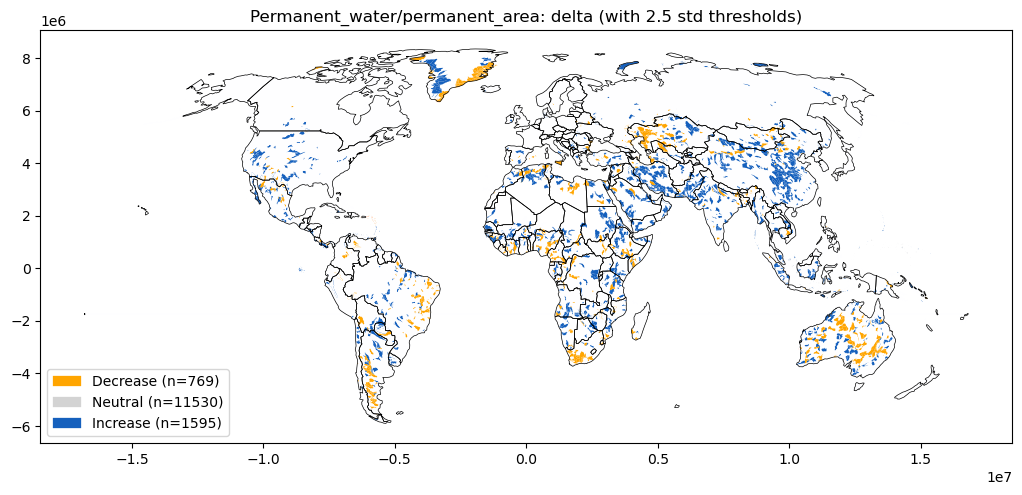

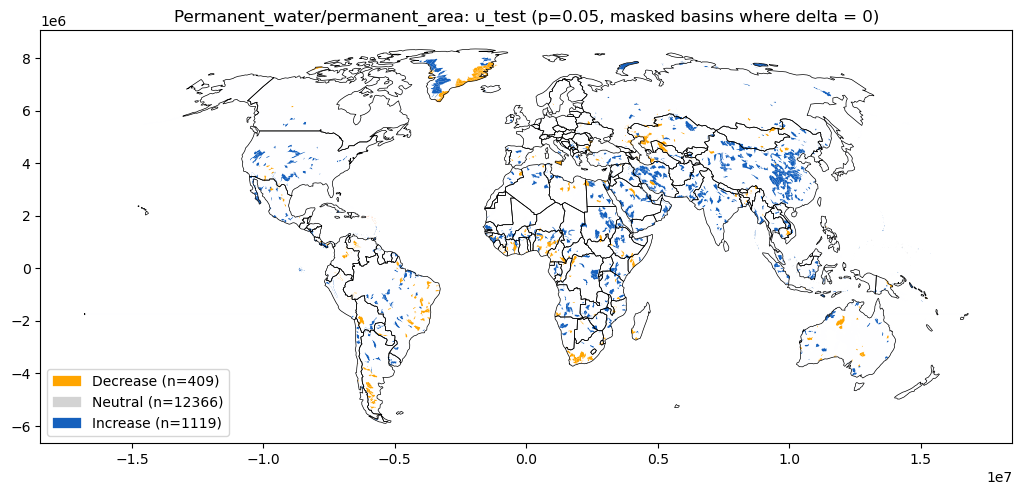

In [59]:
""" Global Map: Delta vs. U-Test """
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
from pathlib import Path

# from cartopy import crs as ccrs
# robinson = ccrs.Robinson().proj4_init

def get_handles(count=[], colors = ['orange', '#d3d3d3', '#1560bd']):
    decrease_handle = mpatches.Patch(color=colors[0], edgecolor="gray", linewidth=0.2, label=f'Decrease (n={count[0]})')
    no_change_handle = mpatches.Patch(color=colors[1], edgecolor="gray", linewidth=0.2, label=f'Neutral (n={count[1]})')
    increase_handle = mpatches.Patch(color=colors[2], edgecolor="gray", linewidth=0.2, label=f'Increase (n={count[2]})')
    return [decrease_handle, no_change_handle, increase_handle]
    # ax.legend(handles=[decrease_handle, no_change_handle, increase_handle])


gdf = gpd.read_file("data\hydrobasin_6\hydrobasin_6.shp")

colors = ['orange', 'white', '#1560bd']
my_colormap = LinearSegmentedColormap.from_list("my_colormap", colors)

countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# countries_filtered = countries[countries.geometry.apply(lambda x: x.bounds[0] > -100)]
countries_flt = countries[countries.geometry.apply(lambda x: x.bounds[1] > -60)].to_crs('+proj=robin')

""" _dissolve: PFAF_ID_6 + Country ID """
masked_basins = gpd.read_file("data\Masked__basins\SNow_Arid_Mask.shp").to_crs('+proj=robin')
gdf_join = gdf.merge(delta_u, on='PFAF_ID', how='right').to_crs('+proj=robin')
gdf_join['PFAF_ID'] = gdf_join['PFAF_ID'].transform(lambda x: str(x))
gdf_join = gdf_join[~gdf_join['PFAF_ID'].isin(list(masked_basins['PFAF_ID_6'].unique()))]

maps_dir = Path('maps') / folder / area
maps_dir.mkdir(exist_ok=True, parents=True)

for col in ['sign', 'u_sign']: # 'sign', 'u_sign'
    fig, ax = plt.subplots(figsize=(12, 5))
    gdf_join.plot(ax=ax, column=col, cmap=my_colormap, vmin=-1, vmax=1)
    # gdf_join.to_crs('+proj=eck4').plot(ax=ax, column='permanent_area', cmap=my_colormap, vmin=-100, vmax=100)
    # masked_basins.plot(ax=ax, color='white', edgecolor='white', linewidth=0.5)
    countries_flt.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)

    plt.tight_layout()

    if 'sign' == col: # delta
        ax.set_title(f'{folder}/{area}: delta (with {alpha} std thresholds)')
        fig.savefig(maps_dir / f'delta_alpha_{alpha}.png', dpi=300)
        print(maps_dir / f'delta_alpha_{alpha}.png')

    if 'u_sign' == col: # utest
        ax.set_title(f'{folder}/{area}: u_test (p={p_thd:.2f}, masked basins where delta = 0)')
        fig.savefig(maps_dir / f'utest_p_{p_thd:.2f}.png', dpi=300)
        print(maps_dir / f'utest_p_{p_thd:.2f}.png')

    neg = gdf_join[gdf_join[col] < 0].shape[0]
    stable = gdf_join[gdf_join[col] == 0].shape[0]
    pos = gdf_join[gdf_join[col] > 0].shape[0]
    ax.legend(handles=get_handles([neg, stable, pos]), loc='lower left') #


In [200]:
""" count number of decresed, stable, and increased basins """
left = delta_u.drop(columns=['p_u_thd_0.01', 'PFAF_ID_y'])
basin_level = 6
method_list = ['delta', 'utest']
rows = []
for idx, col in enumerate(['sign', 'u_sign']):
    method = method_list[idx]
    neg = left[left[col] < 0].shape[0]
    stable = left[left[col] == 0].shape[0]
    pos = left[left[col] > 0].shape[0]

    # print(basin_level, folder, method, neg, stable, pos)
    rows.append([basin_level, folder, method, neg, stable, pos])

df = pd.DataFrame(rows, columns=['basin_level', 'type', 'method', 'decrease', 'stable', 'increase'])
df.to_csv(f"outputs_map/{folder}_basin_level_{basin_level}_count.csv")
df.to_excel(f"outputs_map/{folder}_basin_level_{basin_level}_count.xlsx")

df

6 Pemanent_water delta 1161 15543 2459
6 Pemanent_water utest 560 16914 1689


,id_bgl,start_year,basin_level,permanent_area,PFAF_ID,Country_ID,sign,t_score,u_score,p_t,p_u,u_sign
0,111011_818,2017,6,7.824869e+01,111011,818,1.0,3.630331,95.5,1.696974e-02,0.002221,1.0
1,111012_818,2017,6,2.338167e+14,111012,818,1.0,1.713165,77.5,1.617845e-01,0.008650,1.0
2,111013_818,2017,6,9.493417e+01,111013,818,1.0,4.115081,93.5,5.805082e-03,0.003467,1.0
3,111014_818,2017,6,0.000000e+00,111014,818,0.0,1.428852,NaN,2.262497e-01,0.004884,0.0
4,111015_818,2017,6,2.864859e+01,111015,818,0.0,5.924559,93.5,5.248012e-06,0.003467,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
19158,999999_31,2017,6,1.462119e+01,999999,31,0.0,7.238631,79.5,7.150719e-07,0.048690,0.0
19159,999999_364,2017,6,4.903598e+00,999999,364,0.0,6.995041,79.5,1.108486e-06,0.048690,0.0
19160,999999_398,2017,6,5.591307e+00,999999,398,0.0,6.180404,83.5,2.649143e-06,0.024884,0.0
19161,999999_643,2017,6,4.728585e+00,999999,643,0.0,7.073860,80.5,8.642118e-07,0.041423,0.0


In [ ]:
""" Global Map: Delta vs. U-Test """
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# from cartopy import crs as ccrs
# robinson = ccrs.Robinson().proj4_init

gdf = gpd.read_file("data\hydrobasin_6\hydrobasin_6.shp")
gdf_join = gdf.merge(delta_u, on='PFAF_ID', how='right').to_crs('+proj=robin')

my_colormap = LinearSegmentedColormap.from_list("my_colormap", ['orange', 'white', '#1560bd'])
countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# countries_filtered = countries[countries.geometry.apply(lambda x: x.bounds[0] > -125)]
countries_filtered = countries[countries.geometry.apply(lambda x: x.bounds[1] > -60)].to_crs('+proj=robin')

""" _dissolve: PFAF_ID_6 + Country ID """
masked_basins = gpd.read_file("data\Masked__basins\SNow_Arid_Mask.shp").to_crs('+proj=robin')
gdf_join['PFAF_ID'] = gdf_join['PFAF_ID'].transform(lambda x: str(x))
gdf_join = gdf_join[~gdf_join['PFAF_ID'].isin(list(masked_basins['PFAF_ID_6'].unique()))]